#  Tutorial 10: The Kalman Filter

**By Neuromatch Academy**

adjusted for Prob ML 2022, University of Tuebingen

__Content creators:__ Itzel Olivos Castillo and Xaq Pitkow

__Post-production team:__ Gagana B, Spiros Chavlis

**Useful reference:**
- Roweis, Ghahramani (1998): A unifying review of linear Gaussian Models
- Bishop (2006): Pattern Recognition and Machine Learning

---
# Tutorial Objectives

In this tutorial, we will learn how to infer a *continuous* latent variable using the Kalman filter, which is one version of an Hidden Markov Model HMM.

<br>

In this tutorial, you will:
* Review linear dynamical systems
* Learn about the Kalman filter in one dimension
* Manipulate parameters of a process to see how the Kalman filter behaves
* Think about some core properties of the Kalman filter.

You can imagine this inference process happening as Mission Control tries to locate and track Astrocat.

---
# Setup

### Imports and figure settings


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from collections import namedtuple
from scipy.stats import norm

import ipywidgets as widgets       # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

### Helper functions 

In [64]:
def visualize_Astrocat(s, T):
  plt.plot(s, color='limegreen', lw=2)
  plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  plt.xlabel('Time t')
  plt.ylabel('s(t)')


def plot_measurement(s, m, T):
  plt.plot(s, color='limegreen', lw=2, label='true position')
  plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  plt.plot(m, 'o', color='crimson', lw=2, label='measurement', markersize=5)
  plt.xlabel('Time t')
  plt.ylabel('s(t)')
  plt.legend()
  plt.show()

def plot_function(u=1,v=2,w=3,x=4,y=5,z=6):
    time=np.arange(0,1,0.01)
    df=pd.DataFrame({"Y1":np.sin(time*u*2*np.pi),"y2":np.sin(time*v*2*np.pi),"y3":np.sin(time*w*2*np.pi),
                    "y4":np.sin(time*x*2*np.pi),"y5":np.sin(time*y*2*np.pi),"y6":np.sin(time*z*2*np.pi)})
    df.plot()
    
    
def plot_filter_and_obs(D, initial_guess, process_noise, measurement_noise, s, m, s_, cov_):
    
    
    filter_s_ = np.zeros(T)    # estimate (posterior mean)
    filter_cov_ = np.zeros(T)    # uncertainty (posterior covariance)

    posterior = initial_guess
    filter_s_[0] = posterior.mean
    filter_cov_[0] = posterior.cov

    process_noise_std = np.sqrt(process_noise)
    measurement_noise_std = np.sqrt(measurement_noise)

   
    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T+(T*pscale)])
    ax.set_ylim([smin, smax])

    ax.plot(t, s, color='limegreen', lw=2, label='Astrocat´s trajectory')
    ax.plot([t[-1]], [s[-1]], marker='o', markersize=8, color='limegreen')

    ax.plot(t, m, 'o', color='crimson', lw=2, label='measurements', markersize=5)
    ax.plot([t[-1]], [m[-1]], marker='o', markersize=8, color='crimson')

    ax.plot(t, s_, '--', color='lightgray', lw=2, label='your estimated trajectory')# + res)
    ax.plot([t[-1]], [s_[-1]], marker='o', markersize=8, color='lightgray')

    plt.legend()
    plt.show()
    

gaussian = namedtuple('Gaussian', ['mean', 'cov'])

---
# Section 1: Astrocat Dynamics

## Section 1.1: Simulating Astrocat's movements

### Coding Exercise 1.1: Simulating Astrocat's movements

First, you will simulate how Astrocat moves based on stochastic linear dynamics.

The linear dynamical system $s_t = Ds_{t-1} + w_{t-1}$ determines Astrocat's position $s_t$. $D$ is a scalar that models how Astrocat would like to change its position over time, and $w_t \sim \mathcal{N}(0, \sigma_p^2)$ is white Gaussian noise caused by unreliable actuators in Astrocat's propulsion unit. 

Complete the code below to simulate possible trajectories.

First, execute the following cell to enable the default parameters we will use in this tutorial.

In [65]:
# Fixed params

np.random.seed(0)

T_max = 200
D = 1
tau_min = 1
tau_max = 50
process_noise_min = 0.1
process_noise_max = 10
measurement_noise_min = 0.1
measurement_noise_max = 10

unit_process_noise = np.random.randn(T_max)  # compute all N(0, 1) in advance to speed up time slider
unit_measurement_noise = np.random.randn(T_max)  # compute all N(0, 1) in advance to speed up time slider

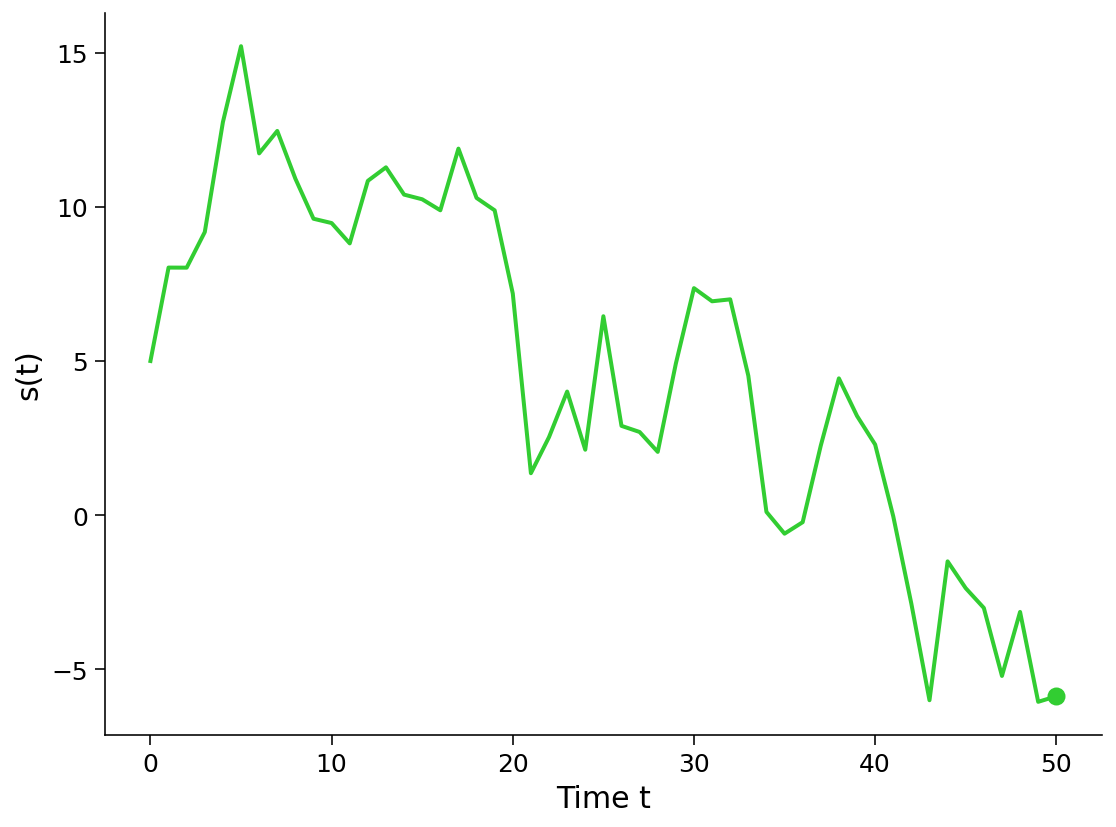

In [66]:
def simulate(D, s0, sigma_p, T):
    """ Compute the response of the linear dynamical system.

    Args:
    D (scalar): dynamics multiplier
    s0 (scalar): initial position
    sigma_p (scalar): amount of noise in the system (standard deviation)
    T (scalar): total duration of the simulation

    Returns:
    ndarray: `s`: astrocat's trajectory up to time T
    """

    # Initialize variables
    s = np.zeros(T+1)
    s[0] = s0

    # Compute the position at time t given the position at time t-1 for all t
    # Consider that np.random.normal(mu, sigma) generates a random sample from
    # a gaussian with mean = mu and standard deviation = sigma

    for t in range(1, len(s)):
        w = np.random.normal(scale=sigma_p)

        # Update position
        s[t] = D * s[t-1] + w

    return s


# Set random seed
np.random.seed(0)

# Set parameters
D = .9      # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Visualize
visualize_Astrocat(s, T)



*Example output:*

<img alt='Solution hint' align='left' width=827.0 height=540.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial3_Solution_3f6505a1_0.png>



### Interactive Demo 1.1: Playing with Astrocat movement

We will use the function you just implemented in a demo, where you can change the value of $D$ and see what happens.

#### Answer the following questions:

1.   What happens when D is large (>1)? Why?
2.   What happens when D is a large negative number (<-1)? Why?
3.   What about when D is zero?


#### Your answers:

1. s behaves exponentially in $D$. Therefore when D>1, it grows exponentially, rendering the small noise almost irrelevant
2. s behaves similarily to $D>1$ but with oscillation from negative to positive
3. $D=0$ means $s$ is just a random walk

#### Execute this cell to enable the demo

In [67]:
@widgets.interact(D=widgets.FloatSlider(value=-.5, min=-2, max=2, step=0.1))
def plot(D=D):

    # Set parameters
    T = 50      # total time duration
    s0 = 5.     # initial condition of s at time 0
    sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit

    # Simulate Astrocat
    s = simulate(D, s0, sigma_p, T)

    # Visualize
    visualize_Astrocat(s, T)

interactive(children=(FloatSlider(value=-0.5, description='D', max=2.0, min=-2.0), Output()), _dom_classes=('w…

## Section 1.2: Measuring Astrocat's movements


### Coding Exercise 1.2.1: Reading measurements from Astrocat's collar



We will estimate Astrocat's actual position using measurements of a noisy sensor attached to its collar. 

Complete the function below to read measurements from Astrocat's collar. These measurements are correct except for additive Gaussian noise whose standard deviation is given by the input argument `sigma_measurements`.

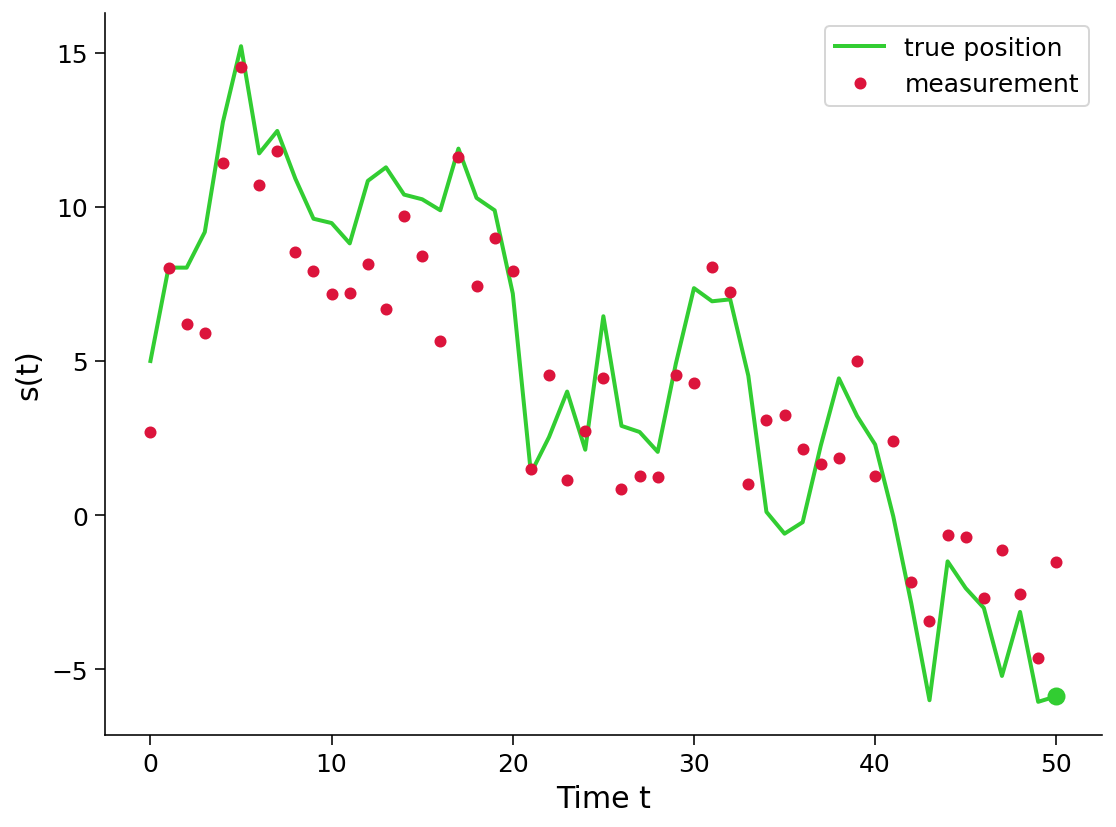

In [68]:
def read_collar(s, sigma_measurements):
    """ Compute the measurements of the noisy sensor attached to astrocat's collar

    Args:
    s (ndarray): astrocat's true position over time
    sigma_measurements (scalar): amount of noise in the sensor (standard deviation)

    Returns:
    ndarray: `m`: astrocat's position over time according to the sensor
    """

    # Initialize variables
    m = np.zeros(len(s))

    # For all time t, add white Gaussian noise with magnitude sigma_measurements
    # Consider that np.random.normal(mu, sigma) generates a random sample from
    # a gaussian with mean = mu and standard deviation = sigma

    for t in range(len(s)):

        w = np.random.normal(scale=sigma_p)

        # Read measurement
        m[t] = D * s[t] + w

    return m


# Set parameters
np.random.seed(0)
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize
plot_measurement(s, m, T)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial3_Solution_95010058_0.png>



### Coding Exercise 1.2.2: Compare true states to measured states



Make a scatter plot to see how bad the measurements of Astrocat's collar are. This exercise will show why using only the measures to track Astrocat can be catastrophic.

A Kalman filter will solve this problem!

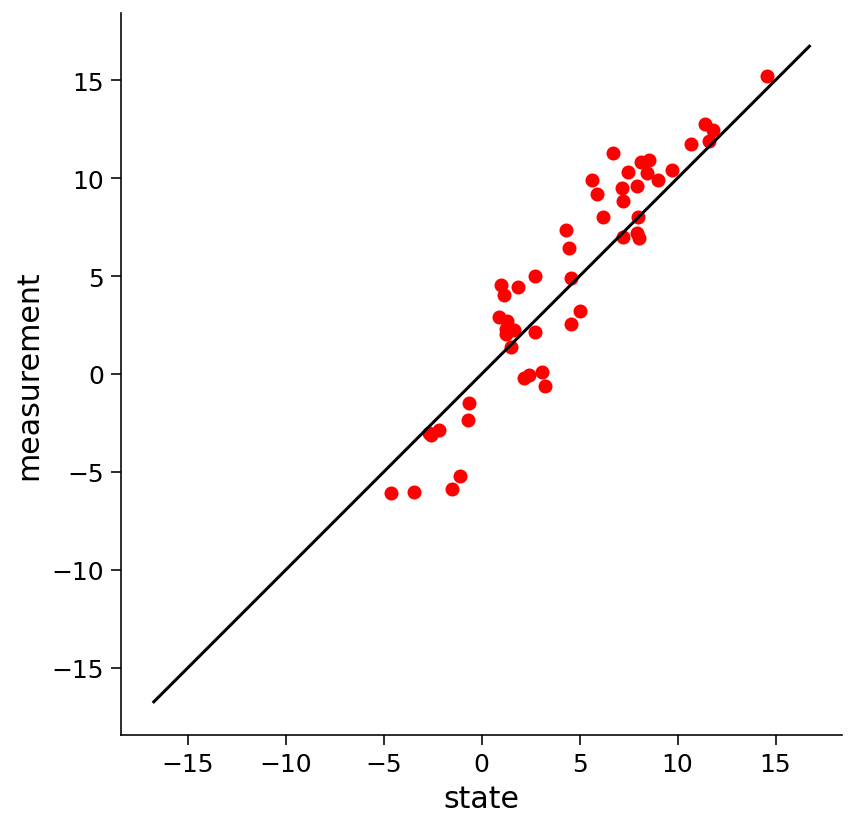

In [69]:
def compare(s, m):
    """ Compute a scatter plot

    Args:
    s (ndarray): astrocat's true position over time
    m (ndarray): astrocat's measured position over time according to the sensor

    """

    fig = plt.figure()
    ax = fig.add_subplot(111)
    sbounds = 1.1*max(max(np.abs(s)), max(np.abs(m)))
    ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
    ax.set_xlabel('state')
    ax.set_ylabel('measurement')
    ax.set_aspect('equal')

    # Complete a scatter plot: true state versus measurements
    ax.scatter(m, s, color='red')


# Set parameters
np.random.seed(0)
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize true vs measured states
compare(s,m)

*Example output:*

<img alt='Solution hint' align='left' width=588.0 height=574.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial3_Solution_303df1e2_0.png>



---
# Section 2: The Kalman filter



### Coding Exercise 2.1: Implement your own Kalman filter



A Kalman filter estimates a posterior probability distribution *recursively* over time using a mathematical model of the process and incoming measurements. This dynamic posterior allows us to improve our guess about Astrocat's position as new measures arrive; besides, its mean is the best estimate one can compute of Astrocat's actual position at each time step.

Now it's your turn! Follow this recipe to complete the code below and implement your own Kalman filter:

**Step 1: Change yesterday's posterior into today's prior** 

Use the mathematical model to calculate how deterministic changes in the process shift yesterday's posterior, $\mathcal{N}(\mu_{s_{t-1}}, \sigma_{s_{t-1}}^2)$, and how random changes in the process broaden the shifted distribution:

> \begin{equation}
p(s_t|m_{1:t-1}) = p(Ds_{t-1}+w_{t-1} | m_{1:t-1}) = \mathcal{N}(D\mu_{s_{t-1}} + 0, D^2\sigma_{s_{t-1}}^2 +\sigma_p^2)
\end{equation}

Note that we use $\sigma_p$ here to denote the process noise.

**Step 2: Multiply today's prior by likelihood** 

Use the latest measurement of Astrocat's collar (fresh evidence) to form a new estimate somewhere between this measurement and what we predicted in Step 1. The next posterior is the result of multiplying the Gaussian computed in Step 1 (a.k.a. today's prior) and the likelihood, which is also modeled as a Gaussian $\mathcal{N}(m_t, \sigma_m^2)$:

**2a: add information from prior and likelihood** 

To find the posterior variance, we first compute the posterior information (which is the inverse of the variance) by adding the information provided by the prior and the likelihood:

> \begin{equation}
\frac{1}{\sigma_{s_t}^2} = \frac{1}{D^2\sigma_{s_{t-1}}^2 +\sigma_p^2} + \frac{1}{\sigma_m^2}
\end{equation}

Now we can take the inverse of the posterior information to get back the posterior variance.

**2b: add means from prior and likelihood** 

To find the posterior mean, we calculate a weighted average of means from prior and likelihood, where each weight, $g$, is just the fraction of information that each Gaussian provides!

> \begin{align}
g_{\rm{prior}} &= \frac{\rm{information}_{\textit{ }\rm{prior}}}{\rm{information}_{\textit{ }\rm{posterior}}} \\
g_{\rm{likelihood}} &= \frac{\rm{information}_{\textit{ }\rm{likelihood}}}{\rm{information}_{\textit{ }\rm{posterior}}} \\
\bar{\mu}_t &= g_{\rm{prior}} D\mu_{s_{t-1}} + g_{\rm{likelihood}} m_t
\end{align}
    
Congrats!

**Implementation detail:** You can access the statistics of a Gaussian by typing, e.g., 

```python
prior.mean
prior.cov
```

**Optional: Relationship to classic description of Kalman filter:**

We're teaching this recipe because it is a bit more interpretable. But the classic description of the Kalman filter is a little different. The above weights, $g_{\rm{prior}}$ and $g_{\rm{likelihood}}$, add up to $1$ and can be written one in terms of the other; then, if we let $K = g_{\rm{likelihood}}$, the posterior mean can be expressed as:

\begin{equation}
\bar{\mu}_t = (1-K) D\bar{\mu}_{t-1} + K m_t = D\bar{\mu}_{t-1} + K (m_t - D\bar{\mu}_{t-1})
\end{equation}

In classic textbooks, you will often find this expression for the posterior mean; $K$ is known as the Kalman gain and its function is to choose a value partway between the current measurement $m_t$ and the prediction from Step 1.

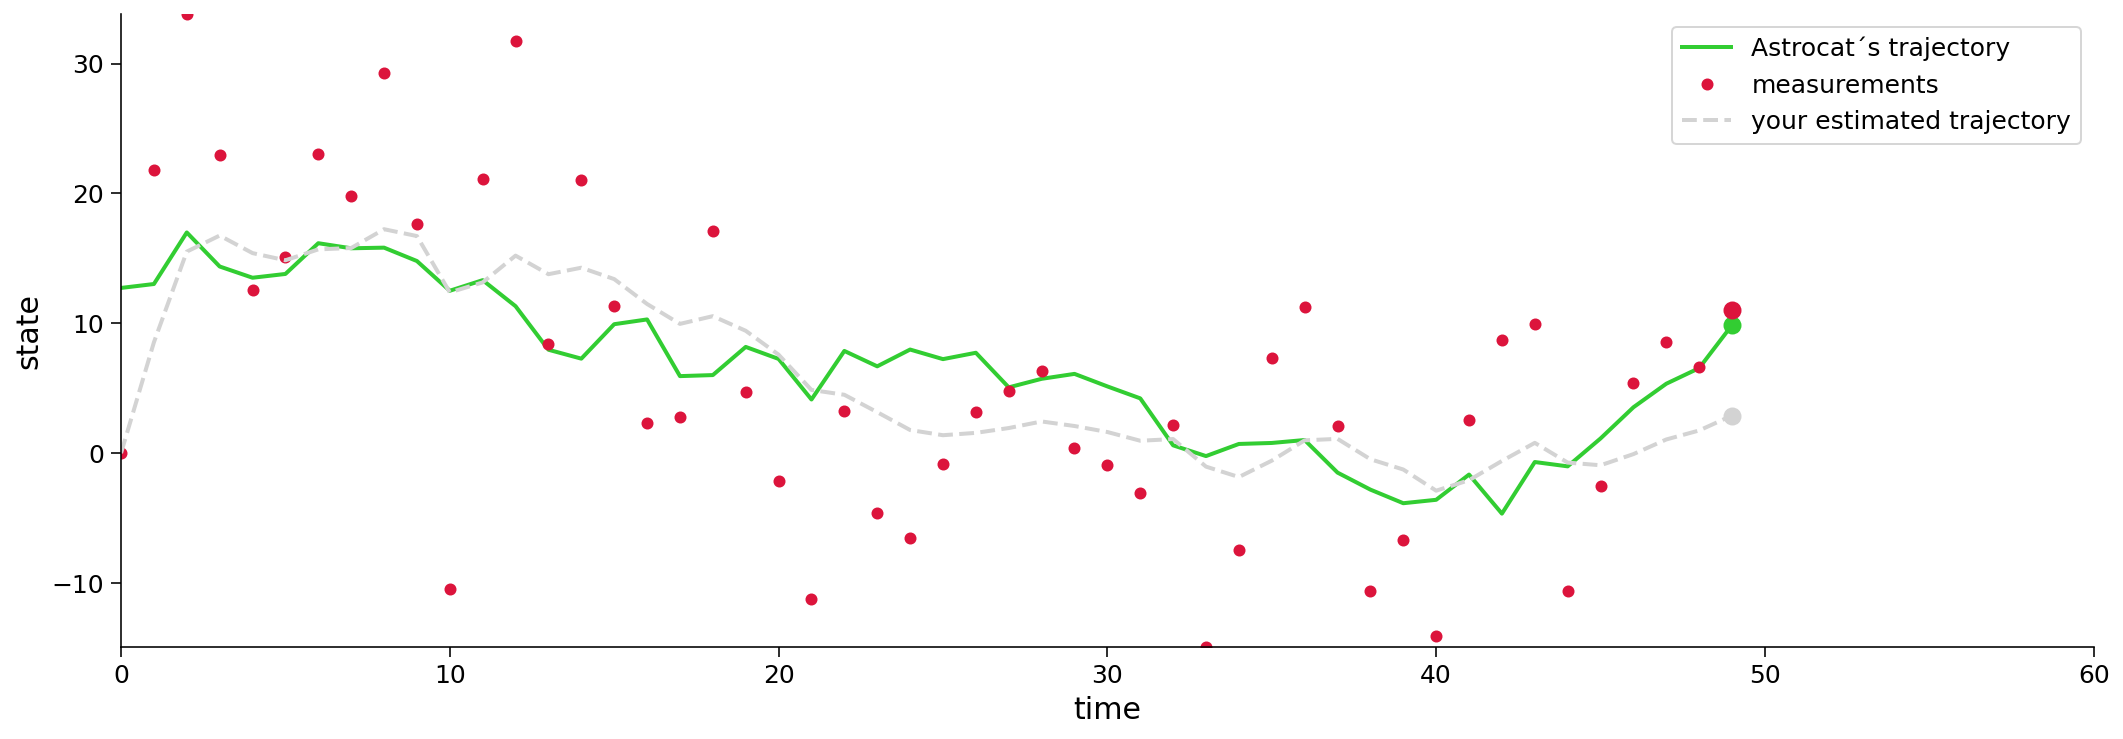

In [81]:
# Set random seed
np.random.seed(0)

# Set parameters
T = 50                  # Time duration
tau = 25                # dynamics time constant
process_noise = 2       # process noise in Astrocat's propulsion unit (standard deviation)
measurement_noise = 9   # measurement noise in Astrocat's collar (standard deviation)

# Auxiliary variables
process_noise_cov = process_noise**2          # process noise in Astrocat's propulsion unit (variance)
measurement_noise_cov = measurement_noise**2  # measurement noise in Astrocat's collar (variance)

# Initialize arrays
t = np.arange(0, T, 1)   # timeline
s = np.zeros(T)          # states
D = np.exp(-1/tau)       # dynamics multiplier (matrix if s is vector)

m = np.zeros(T)          # measurement
s_ = np.zeros(T)         # estimate (posterior mean)
cov_ = np.zeros(T)       # uncertainty (posterior covariance)

# Initial guess of the posterior at time 0
initial_guess = gaussian(0, process_noise_cov/(1-D**2))    # In this case, the initial guess (posterior distribution
                                                           # at time 0) is the equilibrium distribution, but feel free to
                                                           # experiment with other gaussians
posterior = initial_guess

# Sample initial conditions
s[0] = posterior.mean + np.sqrt(posterior.cov) * np.random.randn()   # Sample initial condition from posterior distribution at time 0
s_[0] = posterior.mean
cov_[0] = posterior.cov

# Loop over steps
for i in range(1, T):

    # Sample true states and corresponding measurements
    s[i] = D * s[i-1] + np.random.normal(0, process_noise)    # variable `s` records the true position of Astrocat
    m[i] = s[i] + np.random.normal(0, measurement_noise)      # variable `m` records the measurements of Astrocat's collar

    # Step 1. Shift yesterday's posterior to match the deterministic change of the system's dynamics,
    #         and broad it to account for the random change (i.e., add mean and variance of process noise).
    todays_prior = gaussian(D * s_[i-1], D * cov_[i-1] + process_noise) # this seems very wrong but results in the correct picture
    # todays_prior = gaussian(D * s_[i-1], D**2 * cov_[i-1]**2 + process_noise**2) # this should be how this works
    
    # Step 2. Now that yesterday's posterior has become today's prior, integrate new evidence
    #         (i.e., multiply gaussians from today's prior and likelihood)
    likelihood = gaussian(m[i], measurement_noise**2)

    # Step 2a:  To find the posterior variance, add informations (inverse variances) of prior and likelihood
    info_prior = 1/todays_prior.cov
    info_likelihood = 1/likelihood.cov
    info_posterior = info_prior + info_likelihood

    # Step 2b: To find the posterior mean, calculate a weighted average of means from prior and likelihood;
    #          the weights are just the fraction of information that each gaussian provides!
    prior_weight = info_prior / info_posterior
    likelihood_weight = info_likelihood / info_posterior
    posterior_mean = prior_weight * D * s_[i-1] + likelihood_weight * m[i]

    # Don't forget to convert back posterior information to posterior variance!
    posterior_cov = 1/info_posterior
    posterior = gaussian(posterior_mean, posterior_cov)

    s_[i] = posterior.mean
    cov_[i] = posterior.cov

# Visualize
plot_filter_and_obs(D, initial_guess, process_noise_cov, measurement_noise_cov, s, m, s_, cov_)

*Example output:*

*Note: Please ignore the black line with the label "correct estimated trajectory"*

<img alt='Solution hint' align='left' width=1478.0 height=518.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial3_Solution_6c26b2f4_0.png>



## Section 2.2: Using the Kalman filter


### Interactive Demo 2.2: The Kalman filter in action

Next we provide you with an interactive visualization to understand how the Kalman filter works. Play with the sliders to gain an intuition for how the different factors affect the Kalman filter's inferences. 

The sliders:
* current time: Kalman filter synthesizes measurements up until this time.
* dynamics time constant $\tau$: this determines the dynamics value, $D=\exp^{-\Delta t/\tau}$ where $\Delta t$ is the discrete time step (here 1).
* process noise: amount of noise in the actuators of astrocat's propulsion unit
* observation noise: the noise levels of our measurements (when we read the collar)

#### Answer the following questions:
1. What affects the predictability of Astrocat?
2. How does confidence change over time?
3. What affects the relative weight of the new measurement?
4. How is the error related to the posterior variance?


#### Your answers to the questions:

1. mainly the ratio of process noise to observation noise. if the process noise is much higher, the predictability is high, as the measurements are 'relatively' close to the actual movement and vice versa
2. The confidence is independent of the time
3. Mostly the noise of said measurement, but also $D$ and the process noise
4. the error is the posterior standard deviation

### Coding Exercise 2.2: Write a Kalman filter function

In order to use the interactive widget, write a filter function that basically performs the steps you implemented above again for a single measurement m at a specific timepoint, such that it fits in the code in the cell below. 

In [85]:


def filter(D, process_noise, measurement_noise, posterior, m):

    todays_prior = gaussian(D * posterior.mean, D * posterior.cov + process_noise)
    likelihood = likelihood = gaussian(m, measurement_noise)

    info_prior = 1/todays_prior.cov
    info_likelihood = 1/likelihood.cov
    info_posterior = info_prior + info_likelihood

    prior_weight = info_prior / info_posterior
    likelihood_weight = info_likelihood / info_posterior
    posterior_mean = prior_weight * D * posterior.mean + likelihood_weight * m
    
    posterior_cov = 1/info_posterior
    todays_posterior = gaussian(posterior_mean, posterior_cov)
    
    return todays_prior, likelihood, todays_posterior



In [86]:
# @markdown Execute this cell to enable the demo. It takes a few seconds to update so please be patient.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(T_max/4, description="current time", min=1, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2, description='dynamics time constant', min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2, description="process noise", min=process_noise_min, max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3, description="observation noise", min=measurement_noise_min, max=measurement_noise_max),
                  flag_s = widgets.Checkbox(value=True, description='state', disabled=True, indent=False),
                  flag_m = widgets.Checkbox(value=False, description='measurement', disabled=False, indent=False),
                  flag_s_ = widgets.Checkbox(value=False, description='estimate', disabled=False, indent=False),
                  flag_err_ = widgets.Checkbox(value=False, description='estimator confidence intervals', disabled=False, indent=False))

def stochastic_system(T, tau, process_noise, measurement_noise, flag_m, flag_s_, flag_err_):
    t = np.arange(0, T_max, 1)              # timeline
    s = np.zeros(T_max)                     # states
    D = np.exp(-1/tau)                      # dynamics multiplier (matrix if s is vector)
    process_noise_cov = process_noise**2
    measurement_noise_cov = measurement_noise**2

    prior_mean = 0
    prior_cov = process_noise_cov/(1-D**2)

    s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

    m = np.zeros(T_max)    # measurement
    s_ = np.zeros(T_max)    # estimate (posterior mean)
    cov_ = np.zeros(T_max)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    captured_prior = None
    captured_likelihood = None
    captured_posterior = None

    onfilter = True
    for i in range(1, T_max):
        s[i] = D * s[i-1] + process_noise * unit_process_noise[i-1]

        if onfilter:
            m[i] = s[i] + measurement_noise * unit_measurement_noise[i]

            prior, likelihood, posterior = filter(D, process_noise_cov, measurement_noise_cov, posterior, m[i])

            s_[i] =  posterior.mean
            cov_[i] = posterior.cov

        if i == T:
            onfilter = False
            captured_prior = prior
            captured_likelihood = likelihood
            captured_posterior = posterior

    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T_max+(T_max*pscale)])
    ax.set_ylim([smin, smax])

    show_pdf = [False, False]
    ax.plot(t[:T+1], s[:T+1], color='limegreen', lw=2)
    ax.plot(t[T:], s[T:], color='limegreen', lw=2, alpha=0.3)
    ax.plot([t[T:T+1]], [s[T:T+1]], marker='o', markersize=8, color='limegreen')

    if flag_m:
        ax.plot(t[:T+1], m[:T+1], '.', color='crimson', lw=2, markersize=8)
        ax.plot([t[T:T+1]], [m[T:T+1]], marker='o', markersize=8, color='crimson')

        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_likelihood = norm.pdf(domain, captured_likelihood.mean, np.sqrt(captured_likelihood.cov))
        ax.fill_betweenx(domain, T + pdf_likelihood*(T_max*pscale), T, color='crimson', alpha=0.5, label='likelihood', edgecolor="crimson", linewidth=0)
        ax.plot(T + pdf_likelihood*(T_max*pscale), domain, color='crimson', linewidth=2.0)

        ax.legend(ncol=3, loc='upper left')
        show_pdf[0] = True

    if flag_s_:
        ax.plot(t[:T+1], s_[:T+1], color='black', lw=2)
        ax.plot([t[T:T+1]], [s_[T:T+1]], marker='o', markersize=8, color='black')
        show_pdf[1] = True

    if flag_err_:
        ax.fill_between(t[:T+1], s_[:T+1] + 2 * np.sqrt(cov_)[:T+1], s_[:T+1] - 2 * np.sqrt(cov_)[:T+1], color='black', alpha=0.3)
        show_pdf[1] = True

    if show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_post = norm.pdf(domain, captured_posterior.mean, np.sqrt(captured_posterior.cov))
        ax.fill_betweenx(domain, T + pdf_post*(T_max*pscale), T, color='black', alpha=0.5, label='posterior', edgecolor="black", linewidth=0)
        ax.plot(T + pdf_post*(T_max*pscale), domain, color='black', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

    if show_pdf[0] and show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_prior = norm.pdf(domain, captured_prior.mean, np.sqrt(captured_prior.cov))
        ax.fill_betweenx(domain, T + pdf_prior*(T_max*pscale), T, color='dodgerblue', alpha=0.5, label='prior', edgecolor="dodgerblue", linewidth=0)
        ax.plot(T + pdf_prior*(T_max*pscale), domain, color='dodgerblue', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

plt.show()

interactive(children=(IntSlider(value=50, description='current time', max=199, min=1), FloatSlider(value=25.0,…

## Section 2.2: Estimation accuracy


### Interactive Demo 2.2: Compare states, estimates, and measurements

#### Answer the following questions:
1. How well do the estimates $\hat{s}$ match the actual values $s$? Why? Try different parameters of the Hidden Markov Model and observe how the properties change.
2. How do the _measurements_ $m$ compare to the true states?


#### Your answers to the questions:

1. As expected, a high observation noise paired with a low process noise leads to high errors and vice versa  
$\tau$ does not really have any impact on the errors
2. As we know from how they are generated, the measurements are the true states with noise

In [87]:
# @markdown Execute cell to enable the demo
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(tau=widgets.FloatSlider(tau_max/2, description='tau', min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2, description="process noise", min=process_noise_min, max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3, description="observation noise", min=measurement_noise_min, max=measurement_noise_max),
                  flag_m = widgets.Checkbox(value=False, description='measurements', disabled=False, indent=False))

def stochastic_system(tau, process_noise, measurement_noise, flag_m):
    T = T_max
    t = np.arange(0, T_max, 1)              # timeline
    s = np.zeros(T_max)                     # states
    D = np.exp(-1/tau)                      # dynamics multiplier (matrix if s is vector)

    process_noise_cov = process_noise**2          # process noise in Astrocat's propulsion unit (variance)
    measurement_noise_cov = measurement_noise**2  # measurement noise in Astrocat's collar (variance)

    prior_mean = 0
    prior_cov = process_noise_cov/(1-D**2)


    s[0] = np.sqrt(prior_cov) * np.random.randn()   # Sample initial condition from equilibrium distribution

    m = np.zeros(T_max)    # measurement
    s_ = np.zeros(T_max)    # estimate (posterior mean)
    cov_ = np.zeros(T_max)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    for i in range(1, T):
        s[i] = D * s[i-1] + process_noise * np.random.randn()
        m[i] = s[i] + measurement_noise * np.random.randn()

        prior, likelihood, posterior = filter(D, process_noise_cov, measurement_noise_cov, posterior, m[i])

        s_[i] =  posterior.mean
        cov_[i] = posterior.cov

    fig = plt.figure(figsize=[10, 5])
    ax = plt.subplot(1, 2, 1)
    ax.set_xlabel('s')
    ax.set_ylabel('$\mu$')

    sbounds = 1.1*max(max(np.abs(s)), max(np.abs(s_)), max(np.abs(m)))
    ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
    ax.errorbar(s, s_, yerr=2*np.sqrt(cov_[-1]), marker='.', mfc='black', mec='black', linestyle='none', color='gray')

    axhist = plt.subplot(1, 2, 2)
    axhist.set_xlabel('error $s-\hat{s}$')
    axhist.set_ylabel('probability')
    axhist.hist(s-s_, density=True, bins=25, alpha=.5, label='histogram of estimate errors', color='yellow')

    if flag_m:
        ax.plot(s, m, marker='.', linestyle='none', color='red')
        axhist.hist(s-m,density=True,bins=25,alpha=.5,label='histogram of measurement errors',color='orange')

    domain = np.arange(-sbounds, sbounds, 0.1)
    pdf_g = norm.pdf(domain, 0, np.sqrt(cov_[-1]))
    axhist.fill_between(domain, pdf_g, color='black', alpha=0.5, label=r'posterior shifted to mean')
    axhist.legend()

plt.show()

interactive(children=(FloatSlider(value=25.0, description='tau', max=50.0, min=1.0), FloatSlider(value=2.0, de…

---
# Summary


In this tutorial, you:
- simulated a 1D continuous linear dynamical system and took noisy measurements of the hidden state
- used a Kalman filter to recover the hidden states more accurately than if you just used the noisy measurements and connected this to Bayesian ideas
- played around with parameters of the process to better understand Kalman filter behavior
